In [4]:
%load_ext autoreload 

import pandas as pd
import numpy as np
import os

from collections import defaultdict
from IPython.display import clear_output
from IPython.core.debugger import set_trace
import matplotlib.pyplot as plt
from itertools import combinations
from tqdm import tqdm
from multiprocessing import cpu_count

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from utils import load_dataset, TRIMS

import warnings
warnings.filterwarnings("ignore")

N_CPU = cpu_count()


%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Estimate intrinsic dimension using MLE

run the algorithm MLE of Intristic dimension  
indims and neigh lists are containing the information about intristic dimension estimators and neighborhood sizes   
k1 = 10 # start of interval(included)  
k2 = 100 # end of interval(included)  
    

In [5]:
from manifold_utils import repeated, intrinsic_dim_scale_interval
intdims = defaultdict(dict)

track = 'Circle'
MOUSES = ['22', '23', '24', '25']
DAYS = [1,2,3]

nb_iter = 20
k1 = 5
k2 = 200
neighbors = np.arange(k1, k2, 5)
intdims = defaultdict(dict)

In [10]:
len(neighbors)

39

In [6]:
pca_dims = np.load('./results/pca_dims_cadata_0.99.npy', allow_pickle=True).item()

In [ ]:
for i, mouse in tqdm(enumerate(MOUSES)):
    for j, day in enumerate(DAYS):
        
        trim0, trim1 = TRIMS[day][mouse]        
        data, targets = load_dataset('data', mouse=mouse, day=day, track=track, trims=TRIMS[day][mouse])
        X = data['cadata']
        X -= X.mean(1, keepdims=True)
        
        pca_dim = pca_dims[mouse][day]
        pca = PCA(n_components=pca_dim, random_state=42)
        X_pca = pca.fit_transform(X)
        intdim_k_repeated = repeated(intrinsic_dim_scale_interval, 
                                     X_pca, 
                                     nb_iter=nb_iter, # nb_iter for bootstrapping 
                                     n_jobs=N_CPU//2,
                                     neighbours_range=neighbors)
        
        intdims[mouse][day] = intdim_k_repeated
        
        np.save(f'./results/int_dim/MLE_intdim_M{mouse}_D{day}_{track}', intdim_k_repeated)

0it [00:00, ?it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  9.84it/s]


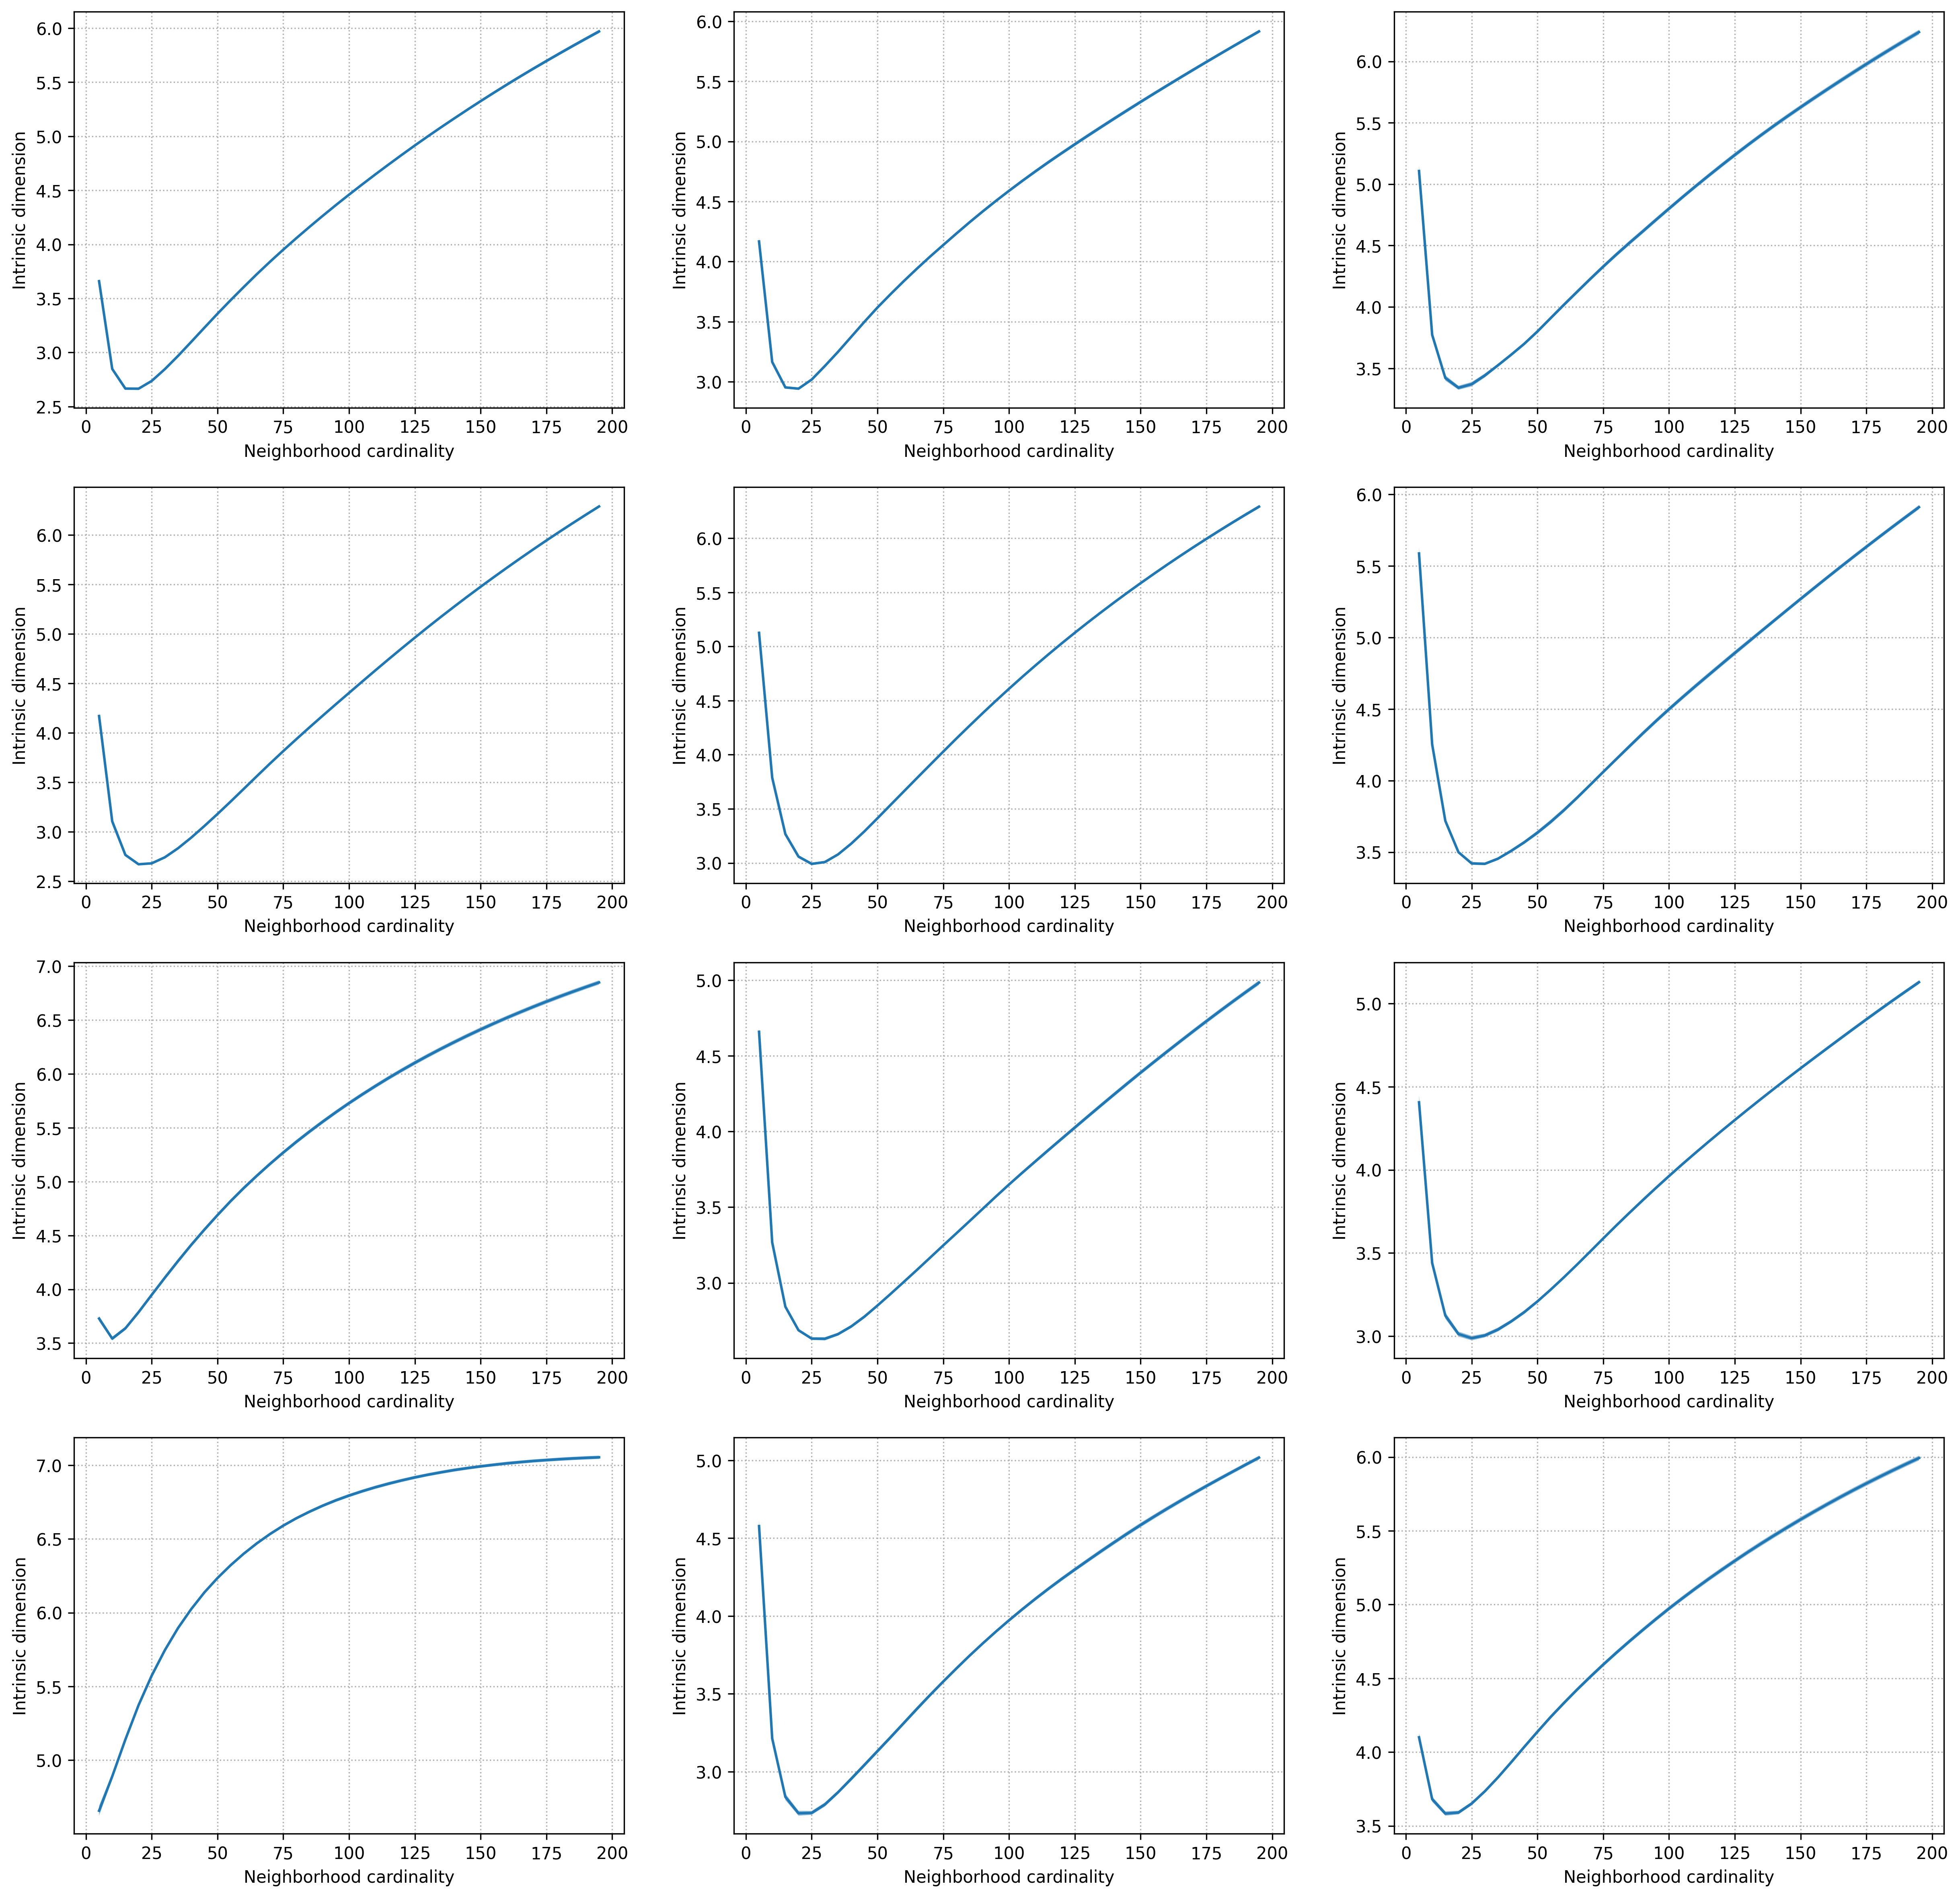

In [28]:
intdims_max = defaultdict(dict)
fig, axes = plt.subplots(ncols=len(DAYS), nrows=len(MOUSES), figsize=(20,20), dpi=300)

for i, mouse in enumerate(MOUSES):
    for j, day in enumerate(DAYS):

        intdim_k_repeated = intdims[mouse][day]
        intdim_k_mean = intdim_k_repeated.mean(0)
        intdim_k_std = intdim_k_repeated.std(0)

        axes[i,j].plot(neighbors, intdim_k_mean)
        axes[i,j].fill_between(neighbors, 
                               intdim_k_mean-intdim_k_std,
                               intdim_k_mean+intdim_k_std,
                               alpha=0.5)

        axes[i,j].set_xlabel("Neighborhood cardinality")
        axes[i,j].set_ylabel("Intrinsic dimension")
        axes[i,j].grid(linestyle='dotted')
        
        intdims_max[mouse][day] = int(intdim_k_repeated.max())

plt.show()

In [31]:
np.save(f'./results/int_dim/MLE_intdim_MAX_{track}', intdims_max)